In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
def d_poly__d_x(x, t, period=100):
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1.13
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)

def F_linear(t):
    x=0
    alpha = 0.01
    if t > 800 and t <= 900:
        x += 1
        return alpha * x
    if t > 900:
        return 1
    else:
        return 0


def F_sigmoid(t):
    scale = 1
    x = 0
    if t > 800:
        x += 1
        return scale * (1 / (1 + np.exp(-x)))
    else:
        return 0

In [6]:
def euler_maruyama_EM_F(X0, dt, epsilon, U_prime, num_steps, num_trajectories, dW, F):

    if num_trajectories == 1:
        X = np.zeros(num_steps + 1)
    else:
        X = np.zeros((num_steps + 1, num_trajectories))
    
    # Set initial condition
    X[0] = X0
    
    for n in range(num_steps):

        t = n * dt
        
        drift = -U_prime(X[n], t) + F(t)
        
        #dW = np.sqrt(dt) * np.random.randn(num_trajectories) if num_trajectories > 1 else np.sqrt(dt) * np.random.randn()
        
        X[n+1] = X[n]  + drift * dt + np.sqrt(epsilon) * dW[n]
    
    return X

def euler_maruyama_EM(X0, dt, epsilon, U_prime, num_steps, num_trajectories, dW):

    if num_trajectories == 1:
        X = np.zeros(num_steps + 1)
    else:
        X = np.zeros((num_steps + 1, num_trajectories))
    
    # Set initial condition
    X[0] = X0
    
    for n in range(num_steps):

        t = n * dt
        
        drift = -U_prime(X[n], t)
        
        #dW = np.sqrt(dt) * np.random.randn(num_trajectories) if num_trajectories > 1 else np.sqrt(dt) * np.random.randn()
        
        X[n+1] = X[n]  + drift * dt + np.sqrt(epsilon) * dW[n]
    
    return X

In [18]:
X0 = 0
dt = 0.01
T = 1000
epsilon = 1
num_steps = int(T/dt)
num_trajectories = 1
dW = [np.sqrt(dt) * np.random.randn() for _ in range(num_steps)]

X_em_F = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW, F_linear)
X_em = euler_maruyama_EM(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW)

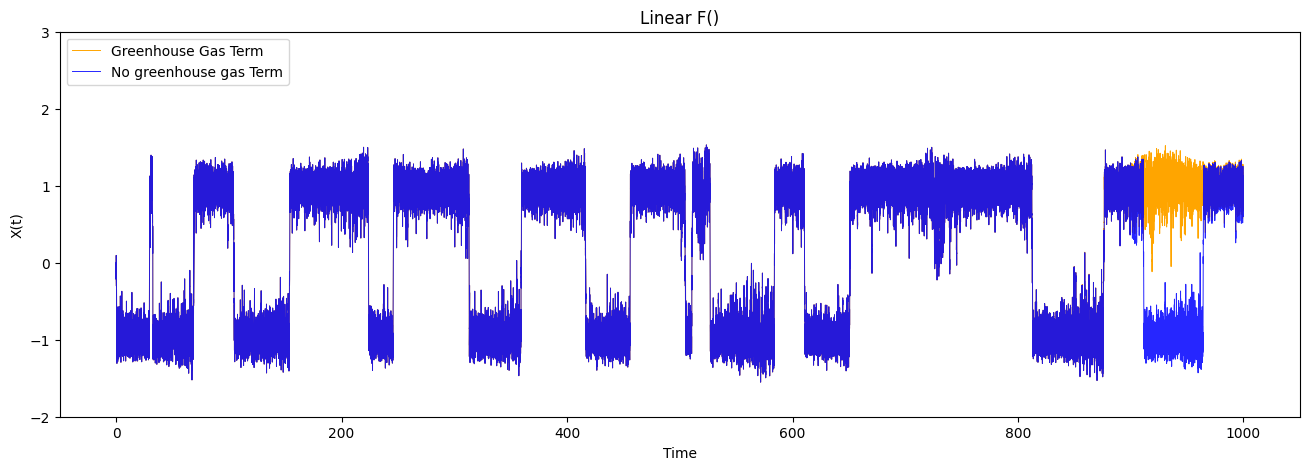

In [30]:
time = np.linspace(0, T, num_steps+1)
plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='orange', linewidth=0.7, label='Greenhouse Gas Term')
plt.plot(time, X_em, color='b', alpha=0.85, linewidth=0.7, label='No greenhouse gas Term')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Linear F()")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.show()

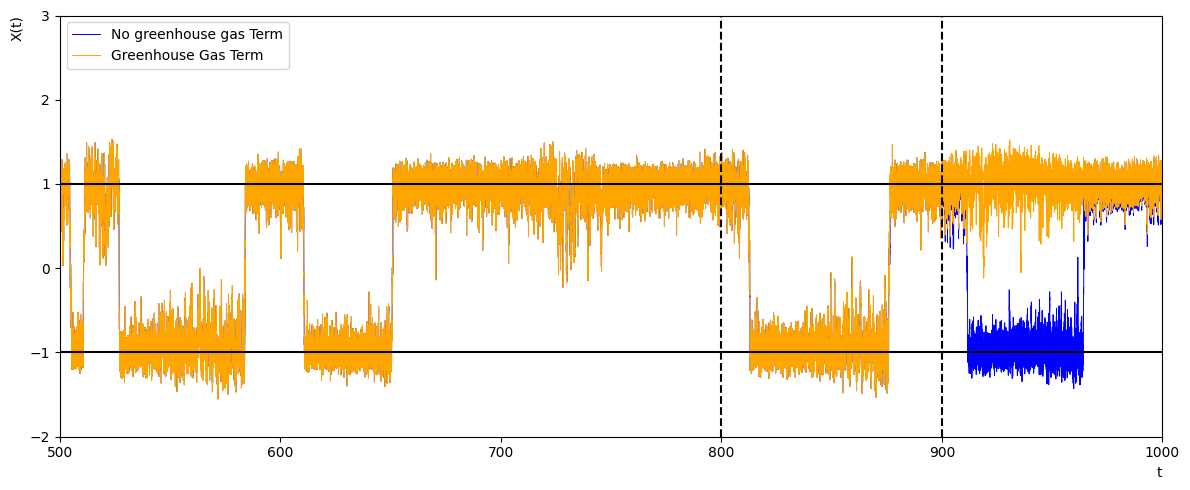

In [43]:
plt.figure(figsize=(12, 5))

# Plot the two trajectories
plt.plot(time, X_em, color='blue', linewidth=0.7, label='No greenhouse gas Term')
plt.plot(time, X_em_F, color='orange', linewidth=0.7, label='Greenhouse Gas Term')

# Add horizontal lines at X(t) = ±1
plt.axhline(y=1, color='black', linestyle='-')
plt.axhline(y=-1, color='black', linestyle='-')

# Add vertical lines at t = 800 and t = 900
plt.axvline(x=800, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')

# Show only the second half of the trajectory on the x-axis
plt.xlim(500, 1000)
plt.ylim(-2, 3)

# Labels, title, legend
plt.xlabel('t', loc='right')
plt.ylabel('X(t)', loc='top')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

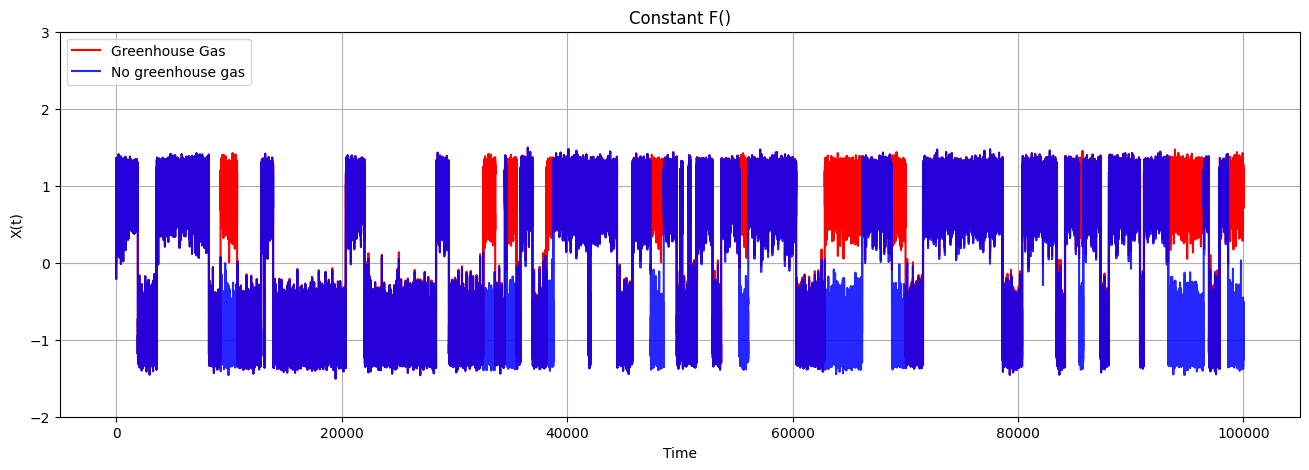

In [ ]:
X0 = 0
dt = 0.01
T = 100000
epsilon = 0.35
num_steps = int(T/dt)
num_trajectories = 1
dW = [np.sqrt(dt) * np.random.randn() for _ in range(num_steps)]

X_em_F = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW, F_linear)
X_em = euler_maruyama_EM(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW)

time = np.linspace(0, T, num_steps+1)

plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='r', label='Greenhouse Gas')
plt.plot(time, X_em, color='b', alpha=0.85, label='No greenhouse gas')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Linear F()")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.grid()
plt.show()

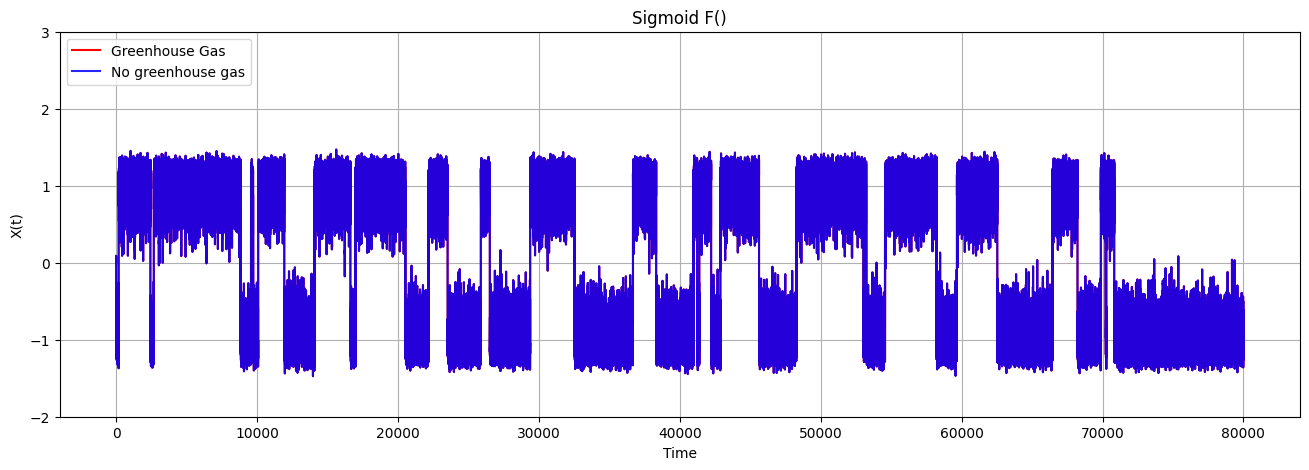

In [24]:
X0 = 0
dt = 0.01
T = 80000
epsilon = 0.35
num_steps = int(T/dt)
num_trajectories = 1
dW = [np.sqrt(dt) * np.random.randn() for _ in range(num_steps)]

X_em_F = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW, F_sigmoid)
X_em = euler_maruyama_EM(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW)

time = np.linspace(0, T, num_steps+1)

plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='r', label='Greenhouse Gas')
plt.plot(time, X_em, color='b', alpha=0.85, label='No greenhouse gas')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Sigmoid F()")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.grid()
plt.show()

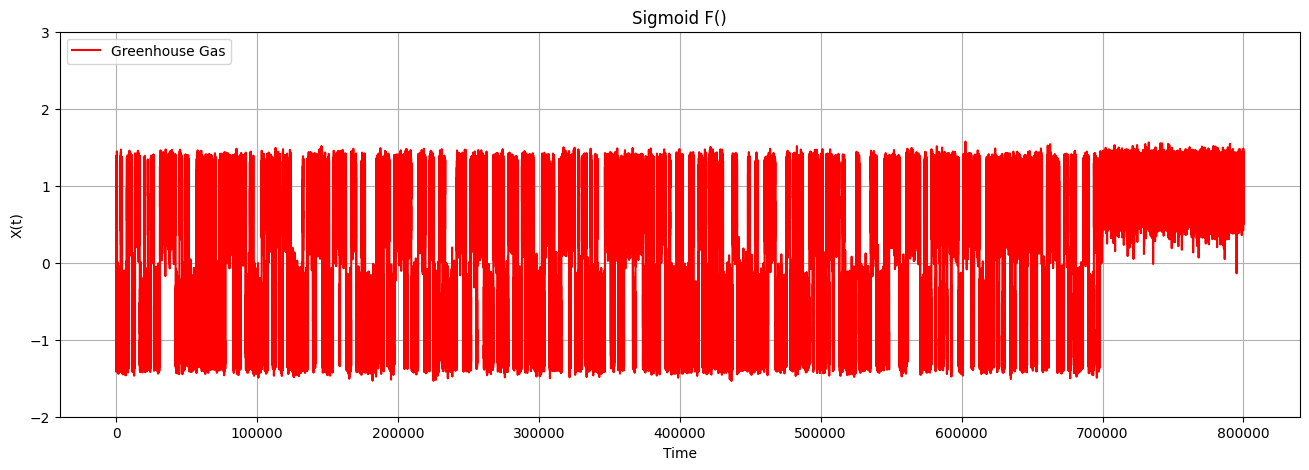

In [19]:
plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='r', label='Greenhouse Gas')
#plt.plot(time, X_em, color='b', alpha=0.85, label='No greenhouse gas')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Sigmoid F()")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.grid()
plt.show()